In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Scikit-learn imports for preprocessing, modeling, and tuning
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
# Load the dataset
df = pd.read_csv('college_student_placement_dataset.csv')

# --- Data Cleaning ---
df.drop_duplicates(inplace=True)
df['Internship_Experience'] = df['Internship_Experience'].map({'Yes': 1, 'No': 0})
df['Placement'] = df['Placement'].map({'Yes': 1, 'No': 0})

# --- Feature Selection ---
features = ['IQ', 'CGPA', 'Internship_Experience', 'Projects_Completed', 'Communication_Skills']
target = 'Placement'

X = df[features]
y = df[target]

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data has been successfully split and scaled.")

Data has been successfully split and scaled.


In [4]:
# Define Models and Parameter Grids for Tuning
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'XGBClassifier': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Define the hyperparameter search space for each model
params = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10, 100]
    },
    'RandomForestClassifier': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBClassifier': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 0.9]
    }
}

# --- Run the Tuning Process ---
best_models = {}
for model_name in models:
    print(f"--- Tuning {model_name} ---")
    
    # Initialize RandomizedSearchCV
    # n_iter=50 means it will try 50 different combinations from the param grid
    # cv=5 means it will use 5-fold cross-validation for robust evaluation
    random_search = RandomizedSearchCV(models[model_name], 
                                       param_distributions=params[model_name], 
                                       n_iter=50, 
                                       cv=5, 
                                       random_state=42, 
                                       n_jobs=-1, # Use all available CPU cores
                                       verbose=1)
    
    # Fit the search to the scaled training data
    random_search.fit(X_train_scaled, y_train)
    
    # Store the best estimator found
    best_models[model_name] = random_search.best_estimator_
    
    print(f"Best Parameters for {model_name}: {random_search.best_params_}")
    print("-" * 30)

--- Tuning LogisticRegression ---
Fitting 5 folds for each of 5 candidates, totalling 25 fits


d:\Placemennt_analysis_pridiction\env\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for LogisticRegression: {'C': 1}
------------------------------
--- Tuning RandomForestClassifier ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for RandomForestClassifier: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 30}
------------------------------
--- Tuning XGBClassifier ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for XGBClassifier: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.01}
------------------------------


d:\Placemennt_analysis_pridiction\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:38:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [5]:
# Evaluate and Compare the Tuned Models
for model_name, model in best_models.items():
    print(f"--- Evaluation for Tuned {model_name} ---")
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(classification_report(y_test, y_pred, target_names=['Not Placed', 'Placed']))
    print("\n")

--- Evaluation for Tuned LogisticRegression ---
Accuracy: 90.30%
              precision    recall  f1-score   support

  Not Placed       0.93      0.96      0.94      1674
      Placed       0.75      0.61      0.67       326

    accuracy                           0.90      2000
   macro avg       0.84      0.78      0.81      2000
weighted avg       0.90      0.90      0.90      2000



--- Evaluation for Tuned RandomForestClassifier ---
Accuracy: 100.00%
              precision    recall  f1-score   support

  Not Placed       1.00      1.00      1.00      1674
      Placed       1.00      1.00      1.00       326

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



--- Evaluation for Tuned XGBClassifier ---
Accuracy: 100.00%
              precision    recall  f1-score   support

  Not Placed       1.00      1.00      1.00      1674
      Placed       1.00      1.00    

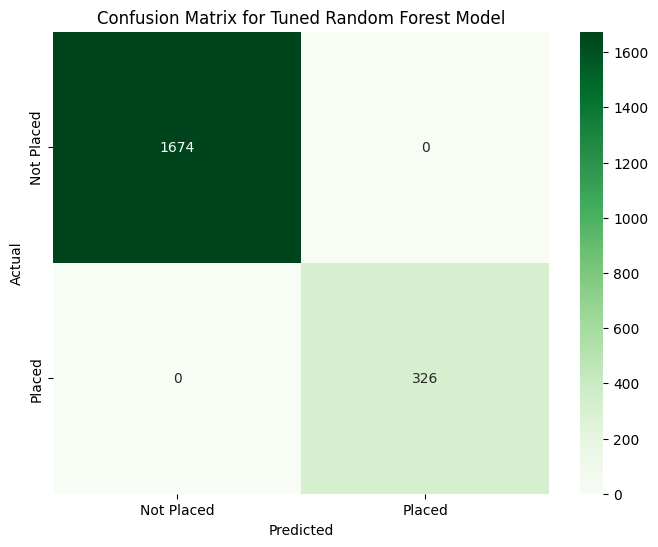

C:\Users\mustafa\AppData\Local\Temp\ipykernel_33736\2843703991.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


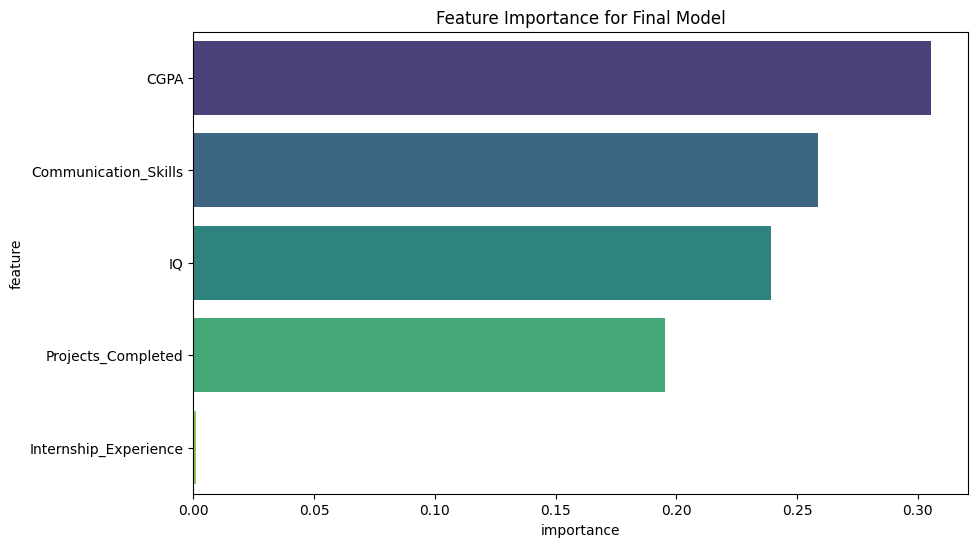

In [6]:
# Final Model Selection and Feature Importance
final_model = best_models['RandomForestClassifier']

# Visualize the confusion matrix for our final, tuned model
y_pred_final = final_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Not Placed', 'Placed'], yticklabels=['Not Placed', 'Placed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Tuned Random Forest Model')
plt.show()

# --- Feature Importance ---
# See which features the model found most important
importances = final_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance for Final Model')
plt.show()

In [7]:
# Save the Final Model and the Scaler
joblib.dump(final_model, 'placement_model_tuned2.joblib')
joblib.dump(scaler, 'scaler.joblib')

print("Optimized model saved as 'placement_model2_tuned.joblib'")
print("Scaler saved as 'scaler.joblib'")

Optimized model saved as 'placement_model2_tuned.joblib'
Scaler saved as 'scaler.joblib'
